In [1]:
# Don't use this or you can't visualise the data for some reason
#import findspark
#import streamlit
#findspark.init()

In [2]:
#Imports
import pyspark
from pyspark import SparkContext, SparkConf
from collections import Counter
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import split, col

from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master('local[10]').config('spark.driver.memory','10g').getOrCreate()

conf = SparkConf().setAppName('Project').setMaster('local')
sparkContext = SparkContext.getOrCreate(conf=conf) #SparkContext(conf = conf)

/usr/local/lib/python3.12/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/01 10:30:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in and assign column names
# Income data
Income = spark.read.csv('income_csv_cleaned_no_commas.csv',header=False)
Income = Income.toDF('Area_code','Area','Self_num_ind','Self_mean','Self_median','Num_ind','Mean','Median','Pens_num_ind','Pens_mean',
                     'Pens_median','Other_num_ind','Other_mean','Other_median','Tot_num_ind','Tot_mean','Tot_median','Tax_num_ind','Tax_mean','Tax_median','Tot_tax')

# Drop not applicable
Income = Income.na.drop()
Income = Income.filter(Income.Area_code!='Not applicable')

# Remove original formatting
Income = Income.filter(Income.Area!='Region/County')

# Population data
Population = spark.read.csv('population_data.csv',header=False)
Population = Population.toDF('Code','Name','Geography','All_ages','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15',
                     '16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37',
                     '38','39','40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59',
                     '60','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86','87','88','89','90+')

# Drop not applicable
Population = Population.na.drop()

# Remove original formatting
Population = Population.filter(Population.Code!='Code')

# Income data
Statements = spark.read.csv('Transposed_Consolidated_Income_Statements.csv',header=False)
Statements = Statements.toDF('Company','Fina_period','State','Revenue','Cost','Gross','Other','Disp_close','Admin','Operating','Fin_out','Fin_in','Share_loss','Before_tax','Tax','Profit')

# Remove original formatting
Statements = Statements.drop(col('Company'))
Statements = Statements.drop(col('Fina_period'))
Statements = Statements.drop(col('State'))

# Remove original formatting
Statements = Statements.filter(Statements.Cost!='Cost of sales')

# Stores data
Stores = spark.read.csv('Stores1.csv',header=False)
Stores = Stores.toDF('Codes','Name','Morrisons','Tesco','Sainsbury')

#Stores.show()

In [4]:
#Population.show()

In [5]:
#Statements.show()

In [6]:
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id

# Condensing the data to only what is relevant
# Dropping self employement data

# Income condensed
Cond_Inc = Income

# Dropping self employment data
Cond_Inc = Cond_Inc.drop(col('Self_num_ind'))
Cond_Inc = Cond_Inc.drop(col('Self_mean'))
Cond_Inc = Cond_Inc.drop(col('Self_median'))

# Dropping pension data
Cond_Inc = Cond_Inc.drop(col('Pens_num_ind'))
Cond_Inc = Cond_Inc.drop(col('Pens_mean'))
Cond_Inc = Cond_Inc.drop(col('Pens_median'))

# Remove the non-applicable areas
Cond_Inc = Cond_Inc.filter(Cond_Inc.Area_code != 'Not applicable')

# Population condensed
Cond_Pop = Population

# Dropping columns for individual ages
for colu in range(0,90):
    Cond_Pop = Cond_Pop.drop('',col(str(colu)))

Cond_Pop = Cond_Pop.drop(col('90+'))

# Dropping repeated data in both population and income
Cond_Pop = Cond_Pop.drop(col('Name'))

# Join two dataframes
Data = Cond_Pop.join(Cond_Inc,Cond_Inc.Area_code == Cond_Pop.Code,'inner')
Data = Data.drop(col('Area_code'))

# Add new primary key
Data = Data.withColumn("id", monotonically_increasing_id())

# Get all codes in the new dataframe
codes = [row.Code for row in Data.select('Code').collect()]

# Temporary store for string data types with primary key
Temp_Store = Data.select('id','Code','Area','Geography')
Temp_Store = Temp_Store.withColumnRenamed('id', 'id1')

# Drop string data type columns
Data = Data.drop(col('Code'))
Data = Data.drop(col('Area'))
Data = Data.drop(col('Geography'))

# Changes data type
for c in Data.columns:
    Data = Data.withColumn(c, F.col(c).cast(IntegerType()))

# Creates a single database
Cast_Data = Data.join(Temp_Store,Data.id == Temp_Store.id1,'full_outer')
Cast_Data = Cast_Data.drop(col('id1'))

Cast_Data = Cast_Data.filter(Cast_Data.id!=0)

Cast_Data.show()

25/04/01 10:30:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+-------------------+
|All_ages|Num_ind| Mean|Median|Other_num_ind|Other_mean|Other_median|Tot_num_ind|Tot_mean|Tot_median|Tax_num_ind|Tax_mean|Tax_median|Tot_tax| id|     Code|                Area|          Geography|
+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+-------------------+
| 2711380|    929|30200| 24700|          508|      3840|          31|       1230|   31500|     24900|       1230|    4110|      2230|   5060|  1|E12000001|          North East|             Region|
| 1153212|    396|30500| 25000|          197|      3800|          29|        508|   31700|     25200|        508|    4120|      2290|   2090|  2|E11000007|         Tyne & Wear|Metropolitan County|
| 7600126|   26

In [7]:
# Regions based data
# Create region table
Region = Cond_Pop.join(Stores,Stores.Codes == Cond_Pop.Code,'inner')
Region = Region.drop(col('Codes'))

#Region = Region.filter(Region.Geography!='Country')

Region.show()

+---------+---------+--------+--------------------+---------+-----+---------+
|     Code|Geography|All_ages|                Name|Morrisons|Tesco|Sainsbury|
+---------+---------+--------+--------------------+---------+-----+---------+
|E92000001|  Country|57690323|             ENGLAND|      506| 2529|     1310|
|E12000001|   Region| 2711380|          NORTH EAST|       31| #N/A|     #N/A|
|E12000002|   Region| 7600126|          NORTH WEST|       67| #N/A|     #N/A|
|E12000003|   Region| 5594125|YORKSHIRE AND THE...|       55| #N/A|     #N/A|
|E12000004|   Region| 4991265|       EAST MIDLANDS|       39| #N/A|     #N/A|
|E12000005|   Region| 6085687|       WEST MIDLANDS|       48| #N/A|     #N/A|
|E12000006|   Region| 6468665|                EAST|       47| #N/A|     #N/A|
|E12000007|   Region| 8945309|              LONDON|       32| #N/A|     #N/A|
|E12000008|   Region| 9482507|          SOUTH EAST|       45| #N/A|     #N/A|
|E12000009|   Region| 5811259|          SOUTH WEST|       48| #N

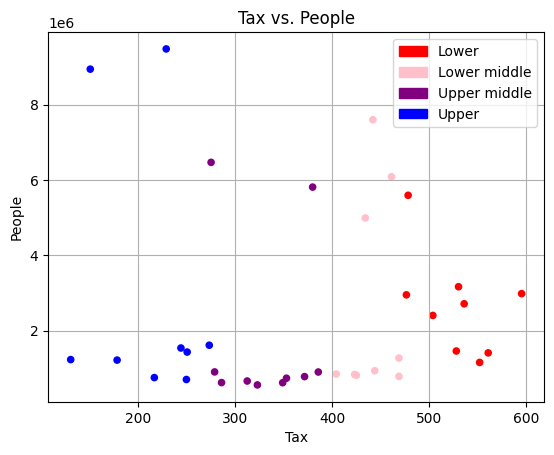

In [8]:
import sys
import matplotlib # pip3 install -U scikit-learn scipy matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

# Convert to Pandas
Pop = Cond_Pop.toPandas() # pip install setuptools
Inc = Cond_Inc.toPandas()
Sta = Statements.toPandas()
Dat = Cast_Data.toPandas()
Reg = Region.toPandas()

# Visualise data
Ages = Dat['All_ages'].values.tolist()
Tax = Dat['Tot_tax'].values.tolist()

# Create blank list
avg_tax = []

for i in range(len(Ages)):
    avg_tax.append(Ages[i]/Tax[i])

'''
# Create line of best fit
z = np.polyfit(x=Dat.loc[:,'All_ages'],y=Dat.loc[:,'Tot_tax'],deg=1)
p = np.poly1d(z)
Dat['Trendline'] = p(Dat.loc[:,'All_ages'])
'''
cat_var = []

# Create category
for i in range(len(avg_tax)):
    if avg_tax[i] > 469:
        cat_var.append('Lower')
    elif avg_tax[i] > 386 and avg_tax[i] < 469:
        cat_var.append('Lower middle')
    elif avg_tax[i] > 275 and avg_tax[i] < 386:
        cat_var.append('Upper middle')
    else:
        cat_var.append('Upper')

# Add cat_var to dataframe
Dat['Class'] = cat_var
Dat['Avg_tax'] = avg_tax

# Create the groups seen in graph
colours = {'Lower': 'red', 'Lower middle': 'pink', 'Upper middle': 'purple', 'Upper': 'blue'}
colour_list = [colours[group] for group in cat_var]

# Create scatter graph
legend_handles = [mpatch.Patch(color=colours['Lower'],label='Lower'),
                  mpatch.Patch(color=colours['Lower middle'],label='Lower middle'),
                  mpatch.Patch(color=colours['Upper middle'],label='Upper middle'),
                  mpatch.Patch(color=colours['Upper'],label='Upper')]

gro_ax = Dat.plot.scatter('Avg_tax','All_ages',c=colour_list,grid=True)
gro_ax.set_title('Tax vs. People')
gro_ax.set_xlabel('Tax')
gro_ax.set_ylabel('People')
gro_ax.legend(handles=legend_handles)

In [9]:
# Creating target data
# Get region details into list
Geo = Dat['Geography'].values.tolist()
Code = Dat['Code'].values.tolist()

# Create blank 2d list
w, h = len(Geo), 2 
District = [[0]*h for i in range(w)]
c = ''

# Connect each district to its relative region
for i in range(0,len(Geo)):
    if Geo[i] == 'Region':
        c = Code[i]
    if Geo[i] == 'Country':
        c = Code[i]
    District[i][0] = c
    District[i][1] = Code[i]

# Get only codes in data dataframe
codes_dat = Dat['Code'].values.tolist()

# Add region to Data dataframe
reg = []
for i in range(0, len(District)):
    reg.append(District[i][0])

Dat['Region'] = reg

# Make a rating for each area
rating = []
Mor = Reg['Morrisons'].values.tolist()
Co_re = Reg['Code'].values.tolist()

# Go through each area, associate the number of shops to it, and make a rating
ratings = []
num_Mor = []
for area in range(0, len(avg_tax)):
    region = reg[area]
    for r in range(0, len(Mor)):
        if Co_re[r] == region:
            shops = Mor[r]
    if region == 'Country':
        ratings.append(0)
        num_Mor.append(shops)
        continue
    num_Mor.append(shops)
    rating = avg_tax[area] // int(shops)
    ratings.append(rating)

Dat['No Morrisons'] = num_Mor
Dat['Rating'] = ratings
display(Dat)

,All_ages,Num_ind,Mean,Median,Other_num_ind,Other_mean,Other_median,Tot_num_ind,Tot_mean,Tot_median,...,Tot_tax,id,Code,Area,Geography,Class,Avg_tax,Region,No Morrisons,Rating
0,2711380,929,30200,24700,508,3840,31,1230,31500,24900,...,5060,1,E12000001,North East,Region,Lower,535.845850,E12000001,31,17.0
1,1153212,396,30500,25000,197,3800,29,508,31700,25200,...,2090,2,E11000007,Tyne & Wear,Metropolitan County,Lower,551.776077,E12000001,31,17.0
2,7600126,2690,32000,25000,1410,5930,43,3490,34000,25700,...,17200,3,E12000002,North West,Region,Lower middle,441.867791,E12000002,67,6.0
3,2948633,1030,31800,25000,500,5730,36,1290,33600,25500,...,6190,4,E11000001,Greater Manchester,Metropolitan County,Lower,476.354281,E12000002,67,7.0
4,1270162,440,30500,24200,265,6250,55,600,32900,25200,...,2710,5,E10000017,Lancashire,County,Lower middle,468.694465,E12000002,67,6.0
5,1456562,503,30500,25000,235,4380,29,642,32000,25200,...,2760,6,E11000002,Merseyside,Metropolitan County,Lower,527.739855,E12000002,67,7.0
6,5594125,1940,30900,24700,1130,5210,43,2550,33000,25300,...,11700,7,E12000003,Yorkshire and the Humber,Region,Lower,478.130342,E12000003,55,8.0
7,1407072,478,29800,24400,260,4130,30,620,31300,24700,...,2510,8,E11000003,South Yorkshire,Metropolitan County,Lower,560.586454,E12000003,55,10.0
8,2402161,816,31200,25200,472,5000,44,1060,32900,25500,...,4770,9,E11000006,West Yorkshire,Metropolitan County,Lower,503.597694,E12000003,55,9.0
9,4991265,1810,31700,25000,1010,5780,47,2380,33800,25800,...,11500,10,E12000004,East Midlands,Region,Lower middle,434.023043,E12000004,39,11.0


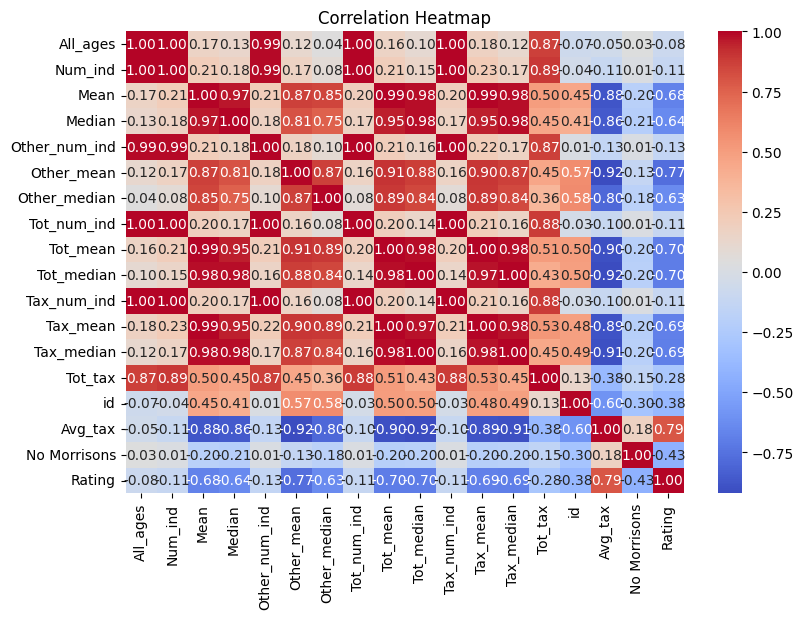

Regression Coefficient (slope):  [24.94828104]
Intercept:  179.93340959801773
Mean Absolute Error: 82.07891636895232
Rppt Mean Squared Error: 92.7881269660228
Coefficient of determination: 0.5511881969256913


In [10]:
# Imports
#from sklearn.ensemble import RandomForestClassifier 
# pip install setuptools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import seaborn as sns # pip install seaborn

# Linear regression and Correlation Matrix

temp_dat = Dat
temp_dat = temp_dat.drop(columns=['Code','Area','Geography','Class','Region'])

# Select predictors
X=Dat[['Rating']]
y=Dat['Avg_tax']

# Correlation matrix
corr_matrix = temp_dat.corr()
plt.figure(figsize=(9,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create classifier
lr = LinearRegression()

# Create model
lr.fit(X_train, y_train)

# Print the regression coefficients
print ('Regression Coefficient (slope): ', lr.coef_)
print('Intercept: ', lr.intercept_)

# Predicts
y_pred = lr.predict(X_test)

# Evaluation
# Compute MAE, RMSE, and R2
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2= r2_score(y_test,y_pred)

# print the evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Rppt Mean Squared Error: {rmse}')
print(f'Coefficient of determination: {r2}')


"\nregTree1 = tree.DecisionTreeRegressor(min_samples_leaf=1)\nregTree1 = regTree1.fit(X_train, y_train)\ny_predict1 = regTree1.predict(X_test)\n\nregTree2 = tree.DecisionTreeRegressor(min_samples_leaf=5)\nregTree2 = regTree2.fit(X_train, y_train)\ny_predict2 = regTree2.predict(X_test)\n\nregTree3 = tree.DecisionTreeRegressor(min_samples_leaf=10)\nregTree3 = regTree3.fit(X_train, y_train)\ny_predict3 = regTree3.predict(X_test)\n\nfig, axs = plt.subplots(3,1,figsize=(7, 18))\n\n\n# plot for min_samples = 1:\naxs[0].plot(X_train,y_train, 'bo')\naxs[0].plot(X_test,y_test, 'g')\n# plot the predicted values:\naxs[0].plot(X_test, y_predict1, 'r')\naxs[0].set_title('min_samples = 1')\n\n# plot for min_samples = 5:\naxs[1].plot(X_train,y_train, 'bo')\naxs[1].plot(X_test,y_test, 'g')\n# plot the predicted values:\naxs[1].plot(X_test, y_predict2, 'r')\naxs[1].set_title('min_samples = 2')\n\n# plot for min_samples = 10:\naxs[2].plot(X_train,y_train, 'bo')\naxs[2].plot(X_test,y_test, 'g')\n# plot t

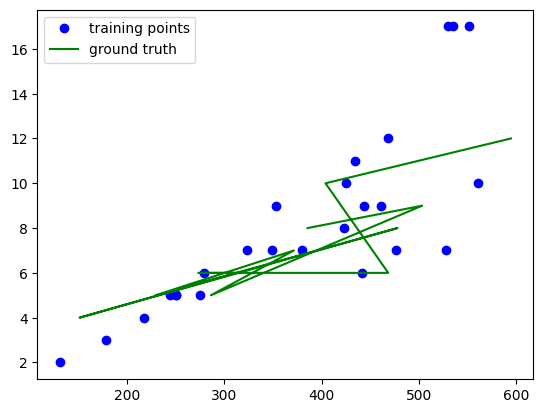

In [11]:
# Decision Tree

from sklearn import tree
import sklearn.metrics as metrics

X=Dat[['Avg_tax']]
y=Dat['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
plt.figure()
plt.clf()
plt.plot(X_train,y_train, 'bo')
plt.plot(X_test,y_test, 'g')
plt.legend(('training points', 'ground truth'))
#plt.show()

'''
regTree1 = tree.DecisionTreeRegressor(min_samples_leaf=1)
regTree1 = regTree1.fit(X_train, y_train)
y_predict1 = regTree1.predict(X_test)

regTree2 = tree.DecisionTreeRegressor(min_samples_leaf=5)
regTree2 = regTree2.fit(X_train, y_train)
y_predict2 = regTree2.predict(X_test)

regTree3 = tree.DecisionTreeRegressor(min_samples_leaf=10)
regTree3 = regTree3.fit(X_train, y_train)
y_predict3 = regTree3.predict(X_test)

fig, axs = plt.subplots(3,1,figsize=(7, 18))


# plot for min_samples = 1:
axs[0].plot(X_train,y_train, 'bo')
axs[0].plot(X_test,y_test, 'g')
# plot the predicted values:
axs[0].plot(X_test, y_predict1, 'r')
axs[0].set_title('min_samples = 1')

# plot for min_samples = 5:
axs[1].plot(X_train,y_train, 'bo')
axs[1].plot(X_test,y_test, 'g')
# plot the predicted values:
axs[1].plot(X_test, y_predict2, 'r')
axs[1].set_title('min_samples = 2')

# plot for min_samples = 10:
axs[2].plot(X_train,y_train, 'bo')
axs[2].plot(X_test,y_test, 'g')
# plot the predicted values:
axs[2].plot(X_test, y_predict3, 'r')
axs[2].set_title('min_samples = 3')

plt.show()

y_predict_train1 = regTree1.predict(X_train)
mseTrainTree1 = metrics.mean_squared_error(y_train, y_predict_train1)
mseTrainTree2 = metrics.mean_squared_error(y_train, regTree2.predict(X_train))
mseTrainTree3 = metrics.mean_squared_error(y_train, regTree3.predict(X_train))

mseTrainTree1, mseTrainTree2, mseTrainTree3
'''

In [12]:
# Gaussian

import pandas as pd
from sklearn.naive_bayes import GaussianNB

label_col = Dat.columns[-1]
feature_cols = Dat.columns[:-1]
print("Label = {}, features = {}".format(label_col, feature_cols))

priors = Dat[label_col].value_counts(normalize = True)
#display(priors)

def likelihood(feature):
    return Dat.groupby(label_col, observed=False)[feature].value_counts(normalize = True)

#print(likelihood('Class'))

Lower = Dat[Dat.Class == 'Lower']
Upper = Dat[Dat.Class == 'Upper']

classes_Dat = pd.get_dummies(Dat.Class)

X = temp_dat.values
y = classes_Dat.Lower.values

random_state = 3

train_idx, test_idx = train_test_split(np.arange(0, X.shape[0]), test_size = 0.6, random_state = random_state)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

model_cont = GaussianNB()
model_cont.fit(X_train, y_train)

confusion_matrix = metrics.confusion_matrix(model_cont.predict(X_test), y_test)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
#disp.plot()
#plt.show()

Label = Rating, features = Index(['All_ages', 'Num_ind', 'Mean', 'Median', 'Other_num_ind', 'Other_mean',
       'Other_median', 'Tot_num_ind', 'Tot_mean', 'Tot_median', 'Tax_num_ind',
       'Tax_mean', 'Tax_median', 'Tot_tax', 'id', 'Code', 'Area', 'Geography',
       'Class', 'Avg_tax', 'Region', 'No Morrisons'],
      dtype='object')
(14, 18) (23, 18)
(14,) (23,)


In [13]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_test, y_test,
                                                                    test_size = 0.5, random_state = random_state)
'''
model_cont = GaussianNB()
model_cont.partial_fit(X_train, y_train, np.unique(y_train))


cm = metrics.confusion_matrix(model_cont.predict(X_test), y_test)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()

cm_small = metrics.confusion_matrix(model_cont.predict(X_test_new), y_test_new)
disp_small = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_small)
#disp_small.plot()


model_cont.partial_fit(X_train_new, y_train_new)

cm_after = metrics.confusion_matrix(model_cont.predict(X_test_new), y_test_new)
disp_after = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_after)
#disp_after.plot()

#plt.show()
'''

'\nmodel_cont = GaussianNB()\nmodel_cont.partial_fit(X_train, y_train, np.unique(y_train))\n\n\ncm = metrics.confusion_matrix(model_cont.predict(X_test), y_test)\ndisp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)\n#disp.plot()\n\ncm_small = metrics.confusion_matrix(model_cont.predict(X_test_new), y_test_new)\ndisp_small = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_small)\n#disp_small.plot()\n\n\nmodel_cont.partial_fit(X_train_new, y_train_new)\n\ncm_after = metrics.confusion_matrix(model_cont.predict(X_test_new), y_test_new)\ndisp_after = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_after)\n#disp_after.plot()\n\n#plt.show()\n'

In [14]:
temp_dat[temp_dat.columns].corr() # Creates a correlation matrix in a table

# Reducing uncorrelated data
X_reduced = Dat[['All_ages','Tot_mean','Tot_median','Tot_tax','Avg_tax','Rating','No Morrisons']].values
X_reduced_train, X_reduced_test = X_reduced[train_idx], X_reduced[test_idx] # Split
model_reduced = GaussianNB() # Create model
model_reduced.fit(X_reduced_train, y_train) # Fit data
pred = model_reduced.predict(X_reduced_test)

cm_reduced = metrics.confusion_matrix(pred, y_test) # Create confusion matrix
disp_after = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_reduced) 
#disp_after.plot()
#plt.show() 

Accuracy: 0.25


/usr/local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'max_depth': 11, 'n_estimators': 264}


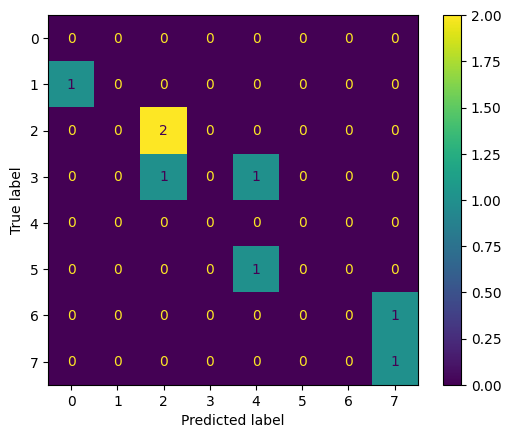

In [20]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

# Imports
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Function to shorten strings
def shorten(x):
    return x[1:]

# Apply function
c = Dat['Code']
n_c = c.apply(shorten)
Dat['Code'] = n_c

r = Dat['Region']
n_r = r.apply(shorten)
Dat['Region'] = n_r

# Change classifier to integer for ease
Dat['Class'] = Dat['Class'].map({'Lower':0,'Lower Middle':1,'Upper Middle':2,'Upper':3,'Unknown':4})

# Define X and y
X = Dat.drop(columns = ['Rating','Area','Geography'],axis=1)
y = Dat['Rating']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train) # Fit data

# Make predictions
y_pred = rf.predict(X_test)

# Get accuracy score for evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Hyperparameter tuning
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import regexp_replace

for rows in Cast_Data.select('Code', 'Region').collect():
    c = rows[0]
    r = rows[1] 
    c_n = rows[0][1:]
    r_n = rows[1][1:]
    Cast_Data = Cast_Data.withColumn('Code', regexp_replace('Code', c, c_n))
    Cast_Data = Cast_Data.withColumn('Region', regexp_replace('Region', r, r_n))

Cast_Data = Cast_Data.withColumn("Code", Cast_Data["Code"].cast(IntegerType()))
Cast_Data = Cast_Data.withColumn("Region", Cast_Data["Region"].cast(IntegerType()))

'''
Cast_Data = spark.createDataFrame(Dat)
Cast_Data = Cast_Data.drop(col('No Morrisons'))
Cast_Data = Cast_Data.drop(col('Geography'))
Cast_Data = Cast_Data.drop(col('Num_ind'))

# Split data
train_data, test_data = Cast_Data.randomSplit([0.8, 0.2])

# Build recommender model
als = ALS(maxIter=5, regParam=0.01, userCol='Region', itemCol='Code', ratingCol='Rating') 

# Fit
model = als.fit(train_data)

# Evaluate
predictions = model.transform(test_data)
predictions.show()

# Drop null
predictions = predictions.na.drop() 

# RMSE
#evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",predictionCol="prediction") 
#rmse = evaluator.evaluate(predictions) 
#print("Root-mean-square error = " + str(rmse))
'''
     

25/04/01 10:31:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/01 10:31:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+--------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+-------+------------------+-----+------------------+-------+------+----------+
|All_ages| Mean|Median|Other_num_ind|Other_mean|Other_median|Tot_num_ind|Tot_mean|Tot_median|Tax_num_ind|Tax_mean|Tax_median|Tot_tax| id|   Code|              Area|Class|           Avg_tax| Region|Rating|prediction|
+--------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+-------+------------------+-----+------------------+-------+------+----------+
| 2711380|30200| 24700|          508|      3840|          31|       1230|   31500|     24900|       1230|    4110|      2230|   5060|  1|2000001|        North East|  0.0| 535.8458498023715|2000001|  17.0|       NaN|
| 7600126|32000| 25000|         1410|      5930|          43|       3490|   34000|     25700|       3490|    4930|      2360|  17200|  3